# EE 769 Project
## HAAR Feature-based Adaboost Cascade Classifier for Face Detection
### Sankalp Bhamare, Vansh Kapoor, and Ankur Verma

In [3]:
import os

import cv2
import numpy as np
from matplotlib import pyplot as plt
import sklearn
from sklearn.linear_model import Perceptron, RidgeClassifier
from skimage.filters import unsharp_mask
import tqdm
from matplotlib import pyplot as plt

## Constants

In [4]:
FACE_SIZE = 19 # size of the face detection kernel

## Integral Image
This is a form of image representation in which each pixel contains the value of integration of rectangle from the top left corner to the current pixel.
Storing information in this way allows the rapid computation of integrals, as shown in the function `get_rect(intg_img, si, sj, ei, ej)`, 

Where `result = intg_img[ei+1, ej+1] - intg_img[si, ej+1] - intg_img[ei+1, sj] + intg_img[si, sj]`

> Inorder to speed up computation, the function call is avoided and directly the elements are accessed and integrals are computed in O(1) time


In [5]:
def compute_intg_image(img):
    """
    Computes matrix for quick computation of integrals.
    """
    # Create a matrix of zeros with the same dimensions as the input image
    intg_img = np.zeros((img.shape[0]+1, img.shape[1]+1) , dtype=np.int64)
    
    # Iterate over each pixel in the input image
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            # Calculate the sum of all pixels above and to the left of the current pixel
            intg_img[i+1, j+1] = intg_img[i, j+1] + intg_img[i+1, j] - intg_img[i, j] + img[i, j]

    # Return the computed integral image
    return intg_img

def get_rect(intg_img, si, sj, ei, ej):
    """
    Computes integral in rect by top left corner to bottom right
    """
    # Calculate the sum of all pixels within the specified rectangular region
    result = intg_img[ei+1, ej+1] - intg_img[si, ej+1] - intg_img[ei+1, sj] + intg_img[si, sj]
    
    # Return the computed sum of pixels
    return result

## Haar Features
Haar filters are a type of feature used in object detection, particularly in face detection. They are simple rectangular filters that can be applied to an image to extract certain features.

Haar filters work by computing the difference in average intensity between adjacent regions in the image. This is done by computing the integral image of the original image and then applying the filter to it. Haar filters come in different shapes and sizes and are applied at different scales to capture features at different levels of detail.


### Types of HAAR Features

#### Type 1
Used for detecting the region between eyes (darker) and cheeks (lighter).

![filters/t11_haar.png](filters/t11_haar.png)

#### Type 2
Used for detecting the region between cheeks (lighter) and nose (darker).

![filters/t22_haar.png](filters/t22_haar.png)

#### Type 3
Used for detecting the nose (darker) with cheeks (lighter) on both the sides.

![filters/t33_haar.png](filters/t33_haar.png)

#### Type 4
Used for detecting eyebrows (darker) with skin (lighter) on both the sides.

![filters/t44_haar.png](filters/t44_haar.png)

### Implementation of HAAR features

The haar features shown above are simple kernel which are applied across the image, to improve performance integral image representation is used wherein all the rectangle integral (conv. over image) can be computed directly using 4 memory access.

The code here implements the method for computation of haar filters and their generation.

In [6]:
def generate_features_from_filter(h, w, filt_type):
    """
    Generates all possible position for a haar filter of a given size.
    """
    gen_features = []
    # Iterate over all possible starting positions for the filter in the image
    for i in range(FACE_SIZE-h+1):
        for j in range(FACE_SIZE-w+1):
            # Append the feature parameters (height, width, filter type, starting row, starting column)
            gen_features.append((h,w, filt_type, i, j))
    return gen_features

def generate_haar_filters():
    """
    Generates all possible haar filter features.
    """
    # Initialize an empty list to hold all generated Haar features
    haar_features= []
    # Iterate over all possible filter heights and widths
    for i in range(1, FACE_SIZE+1):
        for j in range(1, FACE_SIZE+1):
            # Append all possible features that can be generated from this filter type, height, and width
    
            # Check if the filter width is even
            if i % 2 == 0:
                filter_type = 0 # Set the filter type to horizontal
                haar_features += generate_features_from_filter(i, j, filter_type)

            # Check if the filter height is even
            if j % 2 == 0:
                filter_type = 1 # Set the filter type to vertical
                haar_features += generate_features_from_filter(i, j, filter_type)
    
            # Check if the filter width is a multiple of 3
            if j % 3 == 0:
                filter_type = 2 # Set the filter type to vertical
                haar_features += generate_features_from_filter(i, j, filter_type)
    
            # Check if the filter height is a multiple of 3
            if i % 3 == 0:
                filter_type = 3 # Set the filter type to horizontal
                haar_features += generate_features_from_filter(i, j, filter_type)

    return haar_features

def compute_haar_feature(intg_img, haar_feature):
    """
    Compute a haar feature over the intgeral image.
    """
    # extract the parameters of the haar_feature tuple
    h, w, filt_type, i, j = haar_feature
    result = 0

    # compute the haar feature value based on the filter type
    if filt_type == 0:
        result = 2 * ( intg_img[i+h, j+w] - 2*intg_img[i+h//2, j+w] - intg_img[i+h, j] + 2*intg_img[i+h//2, j] + intg_img[i, j+w] - intg_img[i, j]) / (h*w)
    elif filt_type == 1:
        result = 2*(2*intg_img[h + i, j + w//2] - intg_img[h + i, j + w] - intg_img[h + i, j] - 2*intg_img[i, j + w//2] + intg_img[i, j + w] + intg_img[i, j]) / (h*w)
    elif filt_type == 2:
        result = (3*intg_img[h + i, j + 2*w//3] - 3*intg_img[h + i, j + w//3] - intg_img[h + i, j + w] + intg_img[h + i, j] - 3*intg_img[i, j + 2*w//3] + 3*intg_img[i, j + w//3] + intg_img[i, j + w] - intg_img[i, j]) / (h*w) * 1.5
    elif filt_type == 3:
        result = (-intg_img[h + i, j + w] + intg_img[h + i, j] + 3*intg_img[h//3 + i, j + w] - 3*intg_img[h//3 + i, j] - intg_img[i + 2*h//3, j + w] + intg_img[i + 2*h//3, j] - intg_img[i, j + w] + intg_img[i, j])/(h*w)*1.5

    return result


def compute_haar_coef(intg_img, haar_filter_set):
    """
    Compute and return features from a set of haar filter computed on a image.
    """
    return list(np.hstack([compute_haar_feature(intg_img, filt) for filt in haar_filter_set]))


## Loading Dataset
The code below loads the ML dataset used for training the detector

In [7]:
def load_folder(folder):
    """
    Load images from the dataset folder.
    """
    imgs = []
    for file in os.listdir(folder):
        if ".pgm" in file:
            imgs.append(cv2.imread(folder+"/"+file,-1))
    return imgs

def load_data(folder):
    """
    Load images and process them into training data format.
    """
    train_x_true = load_folder(folder+"/face")
    train_x_false = load_folder(folder+"/non-face")

    train_y_true = [1] * len(train_x_true)
    train_y_false = [0] * len(train_x_false)

    train_x = train_x_true + train_x_false
    train_y = train_y_true + train_y_false
    train_x = [compute_intg_image(img) for img in train_x]
    return train_x, train_y

In [8]:
train_x, train_y = load_data("train")
test_x, test_y = load_data("test")

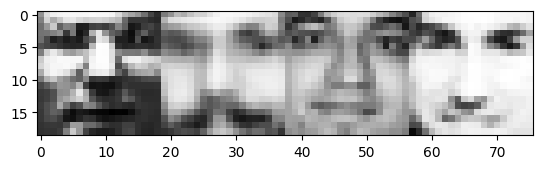

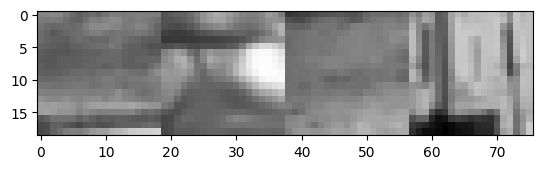

In [26]:
plt.imshow(np.hstack(load_folder("train/face")[:4]), cmap='gray')
plt.show()
plt.imshow(np.hstack(load_folder("train/non-face")[:4]), cmap='gray')

## Adaboost
In this detector we train a set of weak classifiers (ridge classifier) on a set of features and then ensemble them using the adaboost classifier.
The algorithm works as follows:
1. Continue iterations until limit, or no FP:
2. In each iteration train the model on the weighted training data
3. Recompute the weights based on performance of the model and keep repeating until 1.

Once the iterations are done a strong classifier is formed which is ensemble of each of the weak classifiers trained during the iterations

In [10]:
def Adaboost(train_x, train_y, d=1, T=100):
    # Count number of positive and negative examples in the training set
    face_count = 0
    non_face_count = 0
    for i, label in enumerate(train_y):
        if label:
            face_count += 1
        else:
            non_face_count += 1
    # Print number of positive and negative examples
    print(face_count, non_face_count)

    # Initialize weights for each example in the training set
    w = np.array([1/face_count if train_y[i] else 1/non_face_count for i in range(len(train_y))])

    # Initialize lists to hold classifiers, feature selections, and betas
    classifiers = []
    feature_sel = []
    betas = []
    model_threshold = 0

    # Define function to select features given a list of data and a list of selected feature indices
    def select_features(x_data, x_sel):
        return [np.hstack([x[f] for f in x_sel]) for x in x_data]

    # Initialize predictions to be an array of zeros with the same shape as the training labels
    predictions = np.zeros(train_y.shape)

    # Iterate T times to create T classifiers
    for t in range(T):
        # Normalize weights to sum to 1
        w = w / np.sum(w)

        # Repeat until beta < 0.5 (i.e. the classifier performs better than random)
        while True:
            # Initialize a RidgeClassifier and randomly select d features from the training set
            model = RidgeClassifier()
            m_sel = np.random.permutation(len(train_x[0]))[:d]
            m_train_x = select_features(train_x, m_sel)

            # Fit the model to the training data with weights w
            model.fit(m_train_x, train_y, sample_weight=w)

            # Compute error for each example in the training set
            e = np.abs(train_y - model.predict(m_train_x))

            # Compute beta, the weighted error of the classifier
            beta = np.sum(w * e)

            # If the beta is less than 0.5, store the classifier, selected features, and beta
            if beta < 0.5:
                feature_sel.append(m_sel)
                w = w * np.power(beta, 1-e)
                classifiers.append(model)
                betas.append(beta+1e-6)
                break

        # Compute alpha, the weight of the current classifier
        alpha = -np.log(betas)

        # Update predictions with the current classifier's predictions weighted by alpha
        predictions = predictions + alpha[-1]*np.array(classifiers[-1].predict(select_features(train_x, feature_sel[-1])))

        # Compute the model threshold as the minimum prediction value for positive examples
        model_threshold = np.min(predictions[train_y==1])

        # Compute the number of misclassified examples
        miss_classification = np.sum((predictions >= model_threshold) != train_y)

        # Print the current error rate
        print(f'Training Error at round {t}: {miss_classification}')

        # If there are no misclassified examples, stop iterating
        if miss_classification == 0:
            break

    # Define a function to return the final model, which makes predictions based on the weighted sum of all T classifiers
    def model(x):
        preds = np.sum( np.array([c.predict(select_features(x, f_sel)) for c, f_sel in zip(classifiers, feature_sel)]) * alpha.reshape(-1,1), axis=0)
        return preds >= model_threshold
    return model
    

## Training the Cascade

Now inorder, to further improve the performance and at the same time the accuracy, strong classifiers (trained using adaboost) are cascaded.

How do they improve the performance?
The earlier stages are trained using a smaller no. of features compared to the later stages, every feature rich models are tuned, the implied performance benefit is that as soon as a instance is classified as false, it is removed from the pipeline saving future computation of further futures thereby given significant performance gain

In [14]:
haar_filters = generate_haar_filters()
np.random.shuffle(haar_filters)

In [15]:
x = train_x
y = np.array(train_y)

In [16]:
cascade_models = [] # list to store the final cascade of models
cascade_filter_prefix = [] # list to store the number of filters used in each stage

filter_size = 200 # initial size of filters for the first stage
stage_filters = [] # list to store filters for each stage
feature_x = [[] for x in train_x] # list to store computed Haar features for each sample

# loop until convergence (no FP)
while True: 
    # Add filters to the current stage filter list
    stage_filters += haar_filters[:filter_size] 
    print(f"Stage: {len(cascade_models)+1} - {len(stage_filters)}")
    
    # Compute Haar features for each sample using current set of filters
    feature_x = [ feature_x[i]+compute_haar_coef(train_x[i], haar_filters[:filter_size]) for i in range(len(feature_x))] 

    print("training start:")

    # Train Adaboost model
    model=Adaboost(feature_x, y, len(stage_filters)//10, 200) 

    print("---------------")
    
    # Add trained model and no. of filter used to the cascade model list
    cascade_models.append(model) 
    cascade_filter_prefix.append(len(stage_filters))
    
    
    # Remove filters used in this stage from list of available filters
    haar_filters = haar_filters[filter_size+1:] 
    
    # Update filter size for next stag
    filter_size = min(filter_size*2, len(haar_filters)) 

    # Predict labels for current set of features
    y_pred = model(feature_x) 

    # Extract all positive marked (TP and FP) samples and use them to train the next cascade of classifier
    pos_sample = np.argwhere(y_pred==True).flatten() # indices of positive samples

    new_x = [x[i] for i in pos_sample]
    new_y = [y[i] for i in pos_sample]
    feature_x = [feature_x[i] for i in pos_sample]

    # if all labels are correctly predicted, terminate
    if( (y_pred==y).all() ): 
        break

    # set new set of samples for next stage
    x = new_x
    y = np.array(new_y)
    
print("done")


Stage: 2 - 600
training start:
2429 1850
Training Error at round 0: 1850
Training Error at round 1: 1850
Training Error at round 2: 1850
Training Error at round 3: 892
Training Error at round 4: 892
Training Error at round 5: 946
Training Error at round 6: 685
Training Error at round 7: 635
Training Error at round 8: 521
Training Error at round 9: 406
Training Error at round 10: 509
Training Error at round 11: 373
Training Error at round 12: 432
Training Error at round 13: 365
Training Error at round 14: 390
Training Error at round 15: 283
Training Error at round 16: 340
Training Error at round 17: 288
Training Error at round 18: 329
Training Error at round 19: 250
Training Error at round 20: 258
Training Error at round 21: 241
Training Error at round 22: 254
Training Error at round 23: 213
Training Error at round 24: 184
Training Error at round 25: 191
Training Error at round 26: 192
Training Error at round 27: 183
Training Error at round 28: 145
Training Error at round 29: 182
Traini

In [24]:
print(cascade_models)

[<function Adaboost.<locals>.model at 0x1341e4550>, <function Adaboost.<locals>.model at 0x133e1beb0>]


In [17]:
def check_img(img):
    # Compute the integral image
    intg_img = compute_intg_image(img)
    # Initialize some variables
    filt_size = 100
    t_filt = cascade_filter_prefix[0]
    feature_x = []
    p_filt = 0
    # Loop over the cascade models
    for i in range(len(cascade_models)):
        # Select the filters for the current stage
        s_f = stage_filters[p_filt:t_filt]
        # If there are filters, compute the Haar features
        if len(s_f) > 0:
            feature_x += compute_haar_coef(intg_img, s_f)
        # Update the filter index variables
        p_filt = t_filt
        if i+1 < len(cascade_filter_prefix):
            t_filt = cascade_filter_prefix[i+1]
        # Check if the image passes the current stage of the cascade model
        if not(cascade_models[i]([feature_x])):
            return False
    # If the image passes all stages, return True
    return True


## Demo Code
This code launches a live window with live web cam feed to continously run and display the detected faces by marking them using a bounding box.

In [ ]:
vid = cv2.VideoCapture(0)
while(True):
      
    # Read webcam frame
    ret, frame = vid.read()
    
    # Convert the frame to grayscale and resize it
    img = cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), (200,200), interpolation=cv2.INTER_AREA)
    
    # Create a copy of the image to draw bounding boxes on
    cimg = img.copy()
    
    # Set the size of the kernel used for scanning the image
    k_size = 80
    
    # Loop through the image using the kernel with some overlap
    for i in range(0,img.shape[0]-k_size+1, k_size//2):
        for j in range(0,img.shape[1]-k_size+1, k_size//2):
            
            # Check if the current sub-image matches the object being searched for
            if(check_img(cv2.resize(cv2.equalizeHist(img[i:i+k_size, j:j+k_size]), (19,19), interpolation=cv2.INTER_AREA) )):
                
                # If the sub-image matches, draw a bounding box on the copy of the image
                cv2.rectangle(cimg, (j,i), (j+k_size, i+k_size), 255, 2)
    
    # Display the image with the bounding boxes
    cv2.imshow('frame', cimg)
    
    cv2.waitKey(1)
    
# After the loop release the cap object
vid.release()

# Destroy all the windows
cv2.destroyAllWindows()

## Test Performance
We will now evaluate

In [18]:
frame = cv2.imread("test_2.jpeg")
img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
cimg = img.copy()

k_size = 66
# Loop through the image using the kernel with some overlap
for i in range(0,img.shape[0]-k_size+1, k_size//2):
    for j in range(0,img.shape[1]-k_size+1, k_size//2):
        kimg = cv2.rectangle(cimg.copy(), (j,i), (j+k_size, i+k_size), 255, 2)
        # Check if the current sub-image matches the object being searched for
        if(check_img(cv2.resize(img[i:i+k_size, j:j+k_size], (19,19), interpolation=cv2.INTER_AREA)) ):

            # If the sub-image matches, draw a bounding box on the copy of the image
            cv2.rectangle(cimg, (j,i), (j+k_size, i+k_size), 255, 2)
        cv2.imshow("cimg",kimg)
        cv2.waitKey(1)
cv2.imshow("cimg",cimg)
cv2.waitKey(0)

2023-04-30 00:02:07.090 Python[61400:4464187] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/17/kf9r_zz559j0trllxywmgmq00000gn/T/org.python.python.savedState


KeyboardInterrupt: 

## References
1. https://docs.opencv.org/3.4/d2/d99/tutorial_js_face_detection.html
2. P. Viola and M. Jones, "Rapid object detection using a boosted cascade of simple features," Proceedings of the 2001 IEEE Computer Society Conference on Computer Vision and Pattern Recognition. CVPR 2001, Kauai, HI, USA, 2001, pp. I-I, doi: 10.1109/CVPR.2001.990517.
3. https://towardsdatascience.com/face-detection-with-haar-cascade-727f68dafd08

